### Readme
notebook que carga y analiza el fichero JSON con información de repositorios
los datos se han obtenido via API GraphQL y REST API de github

### Carga de librerías y fichero de datos. comprobaciones básicas

In [1]:
# imports de librerías requeridas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import json
from tabulate import tabulate
import locale

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [2]:
#pd.set_option('display.precision', 2)  # Configurar la precisión de decimales

# Configurar la visualización para que los números se muestren en formato europeo
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.'))

In [3]:
DATA_FILE='D:\\Dev\\github-scrapping-02\\Data\\df_clean.json'

# Fichero df_clean.sjon contenia fechas en formato UNIX seconds. Se convirtió a DateTime de nuevo en el siguiente fichero
#DATA_FILE='D:\\Dev\\github-scrapping-02\\Data\\df_clean_w_correct_date.json'

In [4]:
# Leer el archivo JSON y convertir las columnas de fecha
df = pd.read_json(DATA_FILE, orient='records', lines=True, convert_dates=['createdAt', 'pushedAt', 'updatedAt'])

In [5]:
df_copy=df.copy()

In [6]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37120 entries, 0 to 37119
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    37120 non-null  object        
 1   description             35030 non-null  object        
 2   stargazerCount          37120 non-null  int64         
 3   forkCount               37120 non-null  int64         
 4   createdAt               37120 non-null  datetime64[ns]
 5   updatedAt               37120 non-null  datetime64[ns]
 6   pushedAt                37120 non-null  datetime64[ns]
 7   diskUsage               37120 non-null  int64         
 8   isArchived              37120 non-null  bool          
 9   isEmpty                 37120 non-null  bool          
 10  isFork                  37120 non-null  bool          
 11  isInOrganization        37120 non-null  bool          
 12  isPrivate               37120 non-null  bool  

In [7]:
# Definición de las columnas numéricas y categóricas según la estructura de df_copy
# son las varialbes seleccionadas en E3

columnas_numericas = [
    'assignableUsers',
    'contributors',
    'deployments',
    'diskUsage',
    'environments',
    'milestones',
    'releases',
    'language_count'
]

# Definición de columnas categóricas
columnas_categoricas = [
    'hasIssuesEnabled',
    'hasProjectsEnabled',
    'hasSponsorshipsEnabled',
    'hasWikiEnabled',
    'isInOrganization',
    'isTemplate'
]

lennum=len(columnas_numericas)
lencat=len(columnas_categoricas)
# Mostrar los resultados
print("Columnas Numéricas:")
print(lennum, columnas_numericas)
print("\nColumnas Categóricas:")
print(lencat, columnas_categoricas)
print("total: ",lennum+lencat)

Columnas Numéricas:
8 ['assignableUsers', 'contributors', 'deployments', 'diskUsage', 'environments', 'milestones', 'releases', 'language_count']

Columnas Categóricas:
6 ['hasIssuesEnabled', 'hasProjectsEnabled', 'hasSponsorshipsEnabled', 'hasWikiEnabled', 'isInOrganization', 'isTemplate']
total:  14


In [8]:
# Crear una copia del dataframe
df_copy_cluster = df_copy.copy()

# Transformar booleanos en números (0 y 1)
df_copy_cluster[columnas_categoricas] = df_copy_cluster[columnas_categoricas].astype(int)

# Verificar la transformación
df_copy_cluster.head()

,name,description,stargazerCount,forkCount,createdAt,updatedAt,pushedAt,diskUsage,isArchived,isEmpty,...,forks,assignableUsers,deployments,environments,milestones,releases,pullRequests,watchers,reponame,language_count
0,Parsr,"Transforms PDF, Documents and Images into Enri...",5755,306,2019-08-05 12:43:53,2024-09-01 17:24:35,2023-12-03 13:27:21,55148,False,False,...,305,4,0,0,0,26,504,81,axa-group/Parsr,5
1,Yet-Another-EfficientDet-Pytorch,The pytorch re-implement of the official effic...,5200,1268,2020-04-06 03:27:06,2024-08-22 08:04:26,2021-10-24 02:13:31,9068,False,False,...,1251,1,0,0,0,4,37,108,zylo117/Yet-Another-EfficientDet-Pytorch,2
2,nit,Git of Web3 assets,4452,8,2022-04-20 08:21:14,2024-08-08 16:18:20,2024-07-29 14:17:11,548,False,False,...,8,4,0,0,0,4,13,12,numbersprotocol/nit,2
3,new.css,A classless CSS framework to write modern webs...,3946,127,2020-05-03 03:18:57,2024-09-01 17:29:23,2024-03-16 08:40:48,310,False,False,...,112,1,100,2,0,1,43,39,xz/new.css,2
4,golang-notes,Go source code analysis(zh-cn),3941,667,2018-04-04 05:21:51,2024-08-31 01:40:45,2022-07-18 09:30:00,8118,False,False,...,658,1,0,0,0,0,39,186,cch123/golang-notes,4


In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Definir las escalas de normalización y estandarización
scaler_normalizer = MinMaxScaler()
scaler_standardizer = RobustScaler()

# Definir las columnas numéricas y categóricas a usar para la clusterización
columns_to_cluster = columnas_numericas + columnas_categoricas

# Transformar los datos: Normalización
df_normalized = df_copy_cluster.copy()
df_normalized[columns_to_cluster] = scaler_normalizer.fit_transform(df_normalized[columns_to_cluster])

# Transformar los datos: Estandarización
df_standardized = df_copy_cluster.copy()
df_standardized[columns_to_cluster] = scaler_standardizer.fit_transform(df_standardized[columns_to_cluster])

# Mostrar un resumen de las tres versiones de los datos
df_copy_cluster[columns_to_cluster].describe(), df_normalized[columns_to_cluster].describe(), df_standardized[columns_to_cluster].describe()


(       assignableUsers  contributors  deployments      diskUsage  \
 count        37.120,00     37.120,00    37.120,00      37.120,00   
 mean             12,56          9,35        70,11      54.013,99   
 std             127,56         16,72     1.780,88   1.031.953,50   
 min               0,00          0,00         0,00           0,00   
 25%               1,00          1,00         0,00         475,00   
 50%               1,00          3,00         0,00       2.931,00   
 75%               3,00          9,00         0,00      16.806,00   
 max           2.267,00        100,00   287.890,00 105.078.627,00   
 
        environments  milestones  releases  language_count  hasIssuesEnabled  \
 count     37.120,00   37.120,00 37.120,00       37.120,00         37.120,00   
 mean           0,66        0,68     10,18            3,13              0,98   
 std           34,54        4,37     41,43            2,25              0,15   
 min            0,00        0,00      0,00            1,0

In [10]:
# Definir función para aplicar algoritmos de clustering y evaluar resultados

def aplicar_clustering(modelo, df, nombre_modelo, parametros):
    # Ajustar el modelo y predecir clusters
    labels = modelo.fit_predict(df[columns_to_cluster])
    
    # Contar el número de clusters generados
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Restar 1 si hay outliers etiquetados como -1

    # Si solo se encuentra un cluster o ningún cluster, omitir las métricas
    if num_clusters <= 1:
        return {
            "método": nombre_modelo,
            "parámetros": parametros,
            "silhouette": None,
            "davies_bouldin": None,
            "num_clusters": num_clusters
        }
    
    # Calcular métricas solo si hay más de 1 cluster
    silhouette_avg = silhouette_score(df[columns_to_cluster], labels)
    db_score = davies_bouldin_score(df[columns_to_cluster], labels)
    
    return {
        "método": nombre_modelo,
        "parámetros": parametros,
        "silhouette": silhouette_avg,
        "davies_bouldin": db_score,
        "num_clusters": num_clusters
    }



In [11]:
# Ejecutar K-Means, DBSCAN, y Agglomerative Clustering sobre datos sin transformar
resultados = []

# K-Means (sin transformación)
kmeans = KMeans(n_clusters=3, random_state=42)
resultados.append(aplicar_clustering(kmeans, df_copy_cluster, "K-Means", "n_clusters=3"))

# DBSCAN (sin transformación, eps pequeño)
dbscan = DBSCAN(eps=0.5, min_samples=5)
resultados.append(aplicar_clustering(dbscan, df_copy_cluster, "DBSCAN", "eps=0.5, min_samples=5"))

# DBSCAN (sin transformación, eps grande)
dbscan_large = DBSCAN(eps=1.0, min_samples=5)
resultados.append(aplicar_clustering(dbscan_large, df_copy_cluster, "DBSCAN", "eps=1.0, min_samples=5"))

# Agglomerative Clustering (sin transformación)
agg_clust = AgglomerativeClustering(n_clusters=3)
resultados.append(aplicar_clustering(agg_clust, df_copy_cluster, "Agglomerative", "n_clusters=3"))


In [12]:
# Ejecutar los métodos sobre los datos normalizados

# K-Means (normalizado)
kmeans_norm = KMeans(n_clusters=3, random_state=42)
resultados.append(aplicar_clustering(kmeans_norm, df_normalized, "K-Means (Norm)", "n_clusters=3"))

# DBSCAN (normalizado, eps pequeño)
dbscan_norm = DBSCAN(eps=0.5, min_samples=5)
resultados.append(aplicar_clustering(dbscan_norm, df_normalized, "DBSCAN (Norm)", "eps=0.5, min_samples=5"))

# DBSCAN (normalizado, eps grande)
dbscan_large_norm = DBSCAN(eps=1.0, min_samples=5)
resultados.append(aplicar_clustering(dbscan_large_norm, df_normalized, "DBSCAN (Norm)", "eps=1.0, min_samples=5"))

# Agglomerative Clustering (normalizado)
agg_clust_norm = AgglomerativeClustering(n_clusters=3)
resultados.append(aplicar_clustering(agg_clust_norm, df_normalized, "Agglomerative (Norm)", "n_clusters=3"))


In [13]:
# Ejecutar los métodos sobre los datos estandarizados

# K-Means (estandarizado)
kmeans_std = KMeans(n_clusters=3, random_state=42)
resultados.append(aplicar_clustering(kmeans_std, df_standardized, "K-Means (Std)", "n_clusters=3"))

# DBSCAN (estandarizado, eps pequeño)
dbscan_std = DBSCAN(eps=0.5, min_samples=5)
resultados.append(aplicar_clustering(dbscan_std, df_standardized, "DBSCAN (Std)", "eps=0.5, min_samples=5"))

# DBSCAN (estandarizado, eps grande)
dbscan_large_std = DBSCAN(eps=1.0, min_samples=5)
resultados.append(aplicar_clustering(dbscan_large_std, df_standardized, "DBSCAN (Std)", "eps=1.0, min_samples=5"))

# Agglomerative Clustering (estandarizado)
agg_clust_std = AgglomerativeClustering(n_clusters=3)
resultados.append(aplicar_clustering(agg_clust_std, df_standardized, "Agglomerative (Std)", "n_clusters=3"))


KeyboardInterrupt: 

In [ ]:
# Crear un DataFrame con los resultados
# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar resultados
df_resultados


In [ ]:
# Optimización de Hiperparámetros con GridSearchCV

from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClusterMixin

# Definir un scorer personalizado para Silhouette que solo depende de las predicciones
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)  # Obtener etiquetas de clusters
    if len(np.unique(labels)) > 1:  # Verificar que haya más de 1 cluster
        score = silhouette_score(X, labels)  # Calcular Silhouette si es posible
    else:
        score = -1  # Si solo hay un cluster, no tiene sentido calcular el Silhouette
    return score

# Crear un Pipeline para K-Means como ejemplo
pipeline_kmeans = Pipeline([
    ('scaler', MinMaxScaler()),  # Normalización
    ('kmeans', KMeans(random_state=42))  # K-Means clustering
])

# Parámetros que queremos ajustar
param_grid_kmeans = {
     'n_clusters': [2, 3, 4],
    'init': ['k-means++', 'random'],
    'n_init': [10]  # Ajuste a un valor fijo
}

# Usar GridSearchCV con el nuevo scorer personalizado
grid_search_kmeans = GridSearchCV(pipeline_kmeans, param_grid_kmeans, scoring=silhouette_scorer, n_jobs=-1, cv=3)
grid_search_kmeans.fit(df_copy_cluster[columns_to_cluster])

# Resultados
best_kmeans = grid_search_kmeans.best_estimator_
best_params_kmeans = grid_search_kmeans.best_params_
best_score_kmeans = grid_search_kmeans.best_score_

print(f"Mejores parámetros para K-Means: {best_params_kmeans}")
print(f"Mejor coeficiente de Silhouette (K-Means): {best_score_kmeans}")



In [ ]:
# lo mismo para DBSCAN y el jerárquico
# DBSCAN con GridSearchCV y el nuevo scorer
pipeline_dbscan = Pipeline([
    ('scaler', MinMaxScaler()),  # Normalización
    ('dbscan', DBSCAN())  # DBSCAN clustering
])

# Parámetros para ajustar en DBSCAN
param_grid_dbscan = {
    'dbscan__eps': [0.2, 0.5, 1.0],  # Diferentes radios de vecindad
    'dbscan__min_samples': [3, 5, 10]  # Diferentes números mínimos de muestras
}

# Usar GridSearchCV con el nuevo scorer personalizado
grid_search_dbscan = GridSearchCV(pipeline_dbscan, param_grid_dbscan, scoring=silhouette_scorer, cv=3)
grid_search_dbscan.fit(df_copy_cluster[columns_to_cluster])

# Resultados
best_dbscan = grid_search_dbscan.best_estimator_
best_params_dbscan = grid_search_dbscan.best_params_
best_score_dbscan = grid_search_dbscan.best_score_

print(f"Mejores parámetros para DBSCAN: {best_params_dbscan}")
print(f"Mejor coeficiente de Silhouette (DBSCAN): {best_score_dbscan}")


# 3. Agglomerative Clustering con GridSearchCV y el nuevo scorer
pipeline_agg = Pipeline([
    ('scaler', MinMaxScaler()),  # Normalización
    ('agglomerative', AgglomerativeClustering())  # Agglomerative clustering
])

# Parámetros para ajustar en Agglomerative Clustering
param_grid_agg = {
    'agglomerative__n_clusters': [3, 4, 5],  # Diferentes números de clusters
    'agglomerative__linkage': ['ward', 'complete', 'average']  # Diferentes métodos de enlace
}

# Usar GridSearchCV con el nuevo scorer personalizado
grid_search_agg = GridSearchCV(pipeline_agg, param_grid_agg, scoring=silhouette_scorer, cv=3)
grid_search_agg.fit(df_copy_cluster[columns_to_cluster])

# Resultados
best_agg = grid_search_agg.best_estimator_
best_params_agg = grid_search_agg.best_params_
best_score_agg = grid_search_agg.best_score_

print(f"Mejores parámetros para Agglomerative Clustering: {best_params_agg}")
print(f"Mejor coeficiente de Silhouette (Agglomerative): {best_score_agg}")


In [ ]:
columns_to_cluster

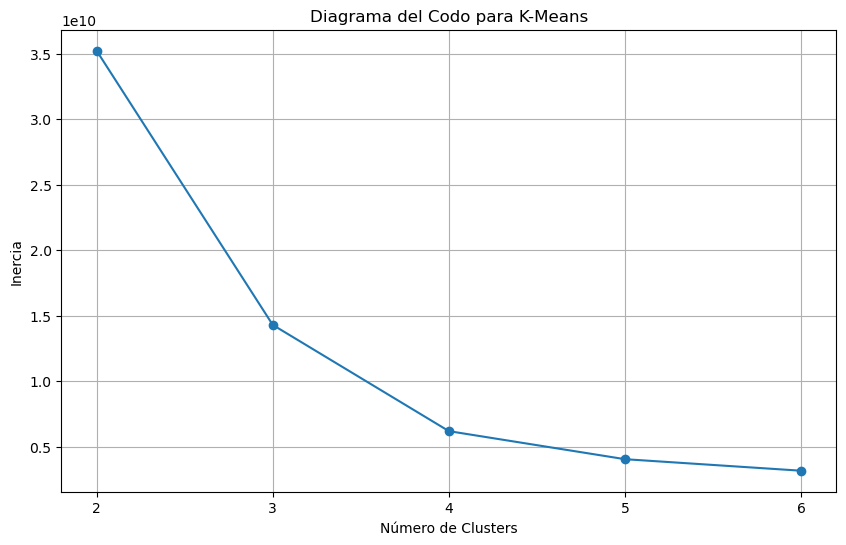

In [14]:
# gráfica del codo para ver numero de clusters
# Lista para almacenar las inercia de cada número de clusters
inertia = []
cluster_range = range(2, 7) 

# Ejecutar K-Means y almacenar la inercia
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_standardized[columns_to_cluster])  # Ajustar el modelo a los datos
    inertia.append(kmeans.inertia_)  # Guardar la inercia

# Dibujar el diagrama del codo
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Diagrama del Codo para K-Means')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.xticks(cluster_range)
plt.grid()
plt.show()

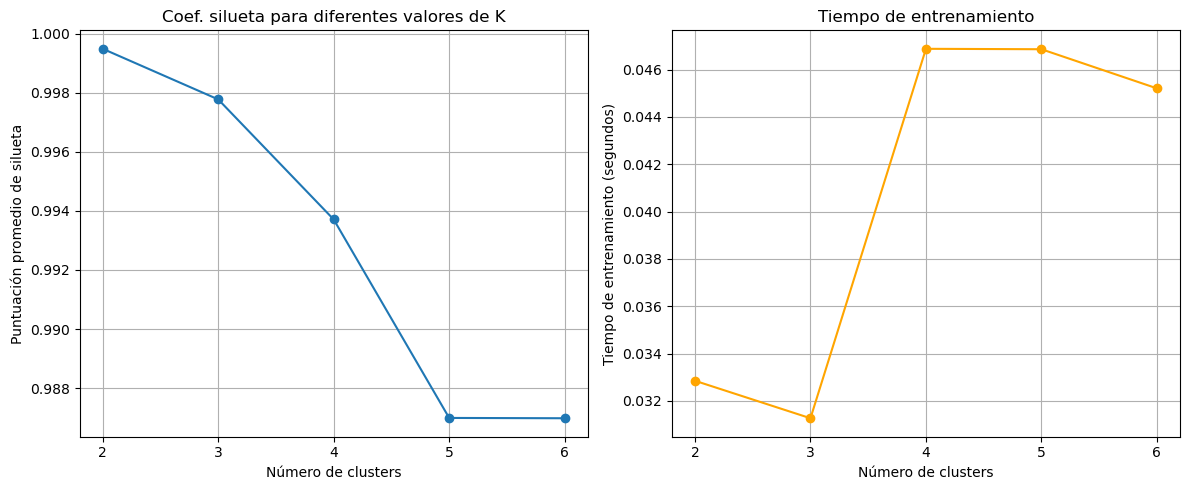

In [15]:
# Definición del rango de números de clusters a evaluar
# gráfica de sillouhette

import time

range_n_clusters = range(2, 7) # el rango mayor no se evalua

# Almacena los resultados de la silueta y los tiempos de entrenamiento
silhouette_avg = []
training_times = []

# Iterar sobre el rango de clusters
for n_clusters in range_n_clusters:
    # Inicializa KMeans con el número actual de clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Registro del tiempo de inicio
    cluster_labels = kmeans.fit_predict(df_standardized[columns_to_cluster])  # Ajustar y predecir los clusters
    end_time = time.time()  # Registro del tiempo final

    # Calcular la puntuación de la silueta
    silhouette_avg.append(silhouette_score(df_standardized[columns_to_cluster], cluster_labels))
    
    # Guardar el tiempo de entrenamiento
    training_times.append(end_time - start_time)

# Visualizar los resultados de la silueta
plt.figure(figsize=(12, 5))

# Gráfico de la puntuación de la silueta
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title('Coef. silueta para diferentes valores de K')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación promedio de silueta')
plt.xticks(range_n_clusters)
plt.grid()

# Gráfico del tiempo de entrenamiento
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, training_times, marker='o', color='orange')
plt.title('Tiempo de entrenamiento')
plt.xlabel('Número de clusters')
plt.ylabel('Tiempo de entrenamiento (segundos)')
plt.xticks(range_n_clusters)
plt.grid()

plt.tight_layout()  # Ajustar el diseño
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# columns_to_cluster son las columnas que deseas usar para clustering

# Seleccionar los datos a utilizar para clustering
data_to_cluster = df_standardized[columns_to_cluster]

# Definir el número de clusters que deseas
n_clusters = 3  # Elige 3 clusters

# Crear el modelo K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Ajustar el modelo a los datos seleccionados
kmeans.fit(data_to_cluster)

# Obtener las etiquetas (labels) de los clusters
cluster_labels = kmeans.labels_

# Añadir las etiquetas al DataFrame df_standardized
df_standardized['Cluster'] = cluster_labels


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Aplicar PCA
pca = PCA()
pca.fit(data_to_cluster)

# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Graficar la varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Varianza Explicada por cada Componente Principal')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.grid()
plt.show()

# Calcular la varianza acumulada para determinar el número óptimo de componentes
cumulative_variance = np.cumsum(explained_variance)
threshold = 0.95  # Umbral para la varianza acumulada

# Encontrar el número de componentes que alcanzan el umbral
n_optimal_components = np.argmax(cumulative_variance >= threshold) + 1  # +1 porque los índices empiezan en 0

n_optimal_components


In [ ]:
df_standardized['Cluster'].unique()

In [ ]:
# Calcular el número de registros en cada cluster y obtener estadísticas
# 1. Calcular el número de registros en cada cluster
cluster_summary = df_standardized.groupby('Cluster').size().reset_index(name='Count')

# 2. Calcular estadísticas descriptivas para cada cluster
# Crear un DataFrame para almacenar las estadísticas
statistics = pd.DataFrame()

# Calcular la media, desviación estándar, mínimo y máximo para cada variable numérica en columns_to_cluster
for column in columns_to_cluster:
    # Asegurarse de que la columna sea numérica
    if pd.api.types.is_numeric_dtype(df_standardized[column]):
        stats = df_standardized.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max']).reset_index()
        stats.rename(columns={
            'mean': f'{column}_Mean',
            'std': f'{column}_Std',
            'min': f'{column}_Min',
            'max': f'{column}_Max'
        }, inplace=True)
        
        # Unir estadísticas en el DataFrame principal
        statistics = pd.merge(statistics, stats, on='Cluster', how='outer') if not statistics.empty else stats

# 3. Unir la cantidad de registros y las estadísticas en un solo DataFrame
summary_table = pd.merge(cluster_summary, statistics, on='Cluster')

# 4. Mostrar la tabla resumen
summary_table
